<a href="https://colab.research.google.com/github/Jiyong-Jeon/GAN_study/blob/main/GAN_In_Action/GAN.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [1]:
%matplotlib inline

import matplotlib.pyplot as plt
import numpy as np

from tensorflow.keras.datasets import mnist
from tensorflow.keras.layers import Dense, Flatten, Reshape, LeakyReLU
from tensorflow.keras.models import Sequential
from tensorflow.keras.optimizers import Adam

In [2]:
img_rows = 28
img_cols = 28
channels = 1

img_shape = (img_rows, img_cols, channels)  # 입력 이미지 차원

z_dim = 100   # 생성자 입력으로 사용될 latent 벡터의 크기

## 생성자
- latent 벡터 z를 입력받아 28 x 28 x 1 이미지 생성
- LeakyReLU 사용
  - 훈련 중 gradient vanishing 방지
- tanh 활성화 함수를 사용하여 출력 값 -1~1 범위로 조정
  - Sigmoid 함수 보다 조금 더 또렷한 이미지를 만듬


In [3]:
def build_generator(img_shape, z_dim):
    model = Sequential()
    model.add(Dense(128, input_dim=z_dim))
    model.add(LeakyReLU(alpha=0.01))
    model.add(Dense(28 * 28 * 1, activation='tanh'))
    model.add(Reshape(img_shape))
    return model

## 판별자
- 28 x 28 x 1 이미지를 받아 가짜와 비교해 얼마나 진짜인지 나타내는 확률을 출력
- 생성자와 유사하게
  - 꼭 비슷할 필요가 없음
  - 실제 대부분의 GAN 구현에서 생성자와 판별자 네트워크 구조는 크기와 복잡도가 매우 다름
- 출력층에 Sigmoid 활성화 함수
  - 출력값을 0~1사이로 하여 확률로 해석할 수 있도록 함

In [4]:
def build_discriminator(img_shape):
    model = Sequential()
    model.add(Flatten(input_shape=img_shape))
    model.add(Dense(128))
    model.add(LeakyReLU(alpha=0.01))
    model.add(Dense(1, activation='sigmoid'))
    return model

## GAN 모델 생성
- 생성자를 훈련할 때 판별자는 파라미터를 동결
- 판별자는 독립적으로 컴파일된 모델로 훈련함

In [5]:
def build_gan(generator, discriminator):
    model = Sequential()
    model.add(generator)
    model.add(discriminator)
    return model # 생성자 -> 판별자로 연결된 모델

In [6]:
# 판별자 모델을 만들고 컴파일하기
discriminator = build_discriminator(img_shape)
discriminator.compile(loss='binary_crossentropy',
                      optimizer=Adam(),
                      metrics=['accuracy'])

# 생성자 모델 만들기
generator = build_generator(img_shape, z_dim)

# 생성자를 훈련하는 동안 판별자의 파라미터를 유지
discriminator.trainable = False

# 생성자를 훈련하기 위해 동결된 판별자로 GAN 모델을 만들고 컴파일
gan = build_gan(generator, discriminator)
gan.compile(loss='binary_crossentropy', optimizer=Adam())

## GAN 훈련 및 출력

In [7]:
losses = []
accuracies = []
iteration_checkpoints = []

def train(iterations, batch_size, sample_interval):
    # MNIST 데이터셋 로드
    (X_train, _), (_, _) = mnist.load_data()
    # [0, 255] 흑백 픽셀 값을 [-1, 1] 사이로 스케일 조정
    X_train = X_train / 127.5 - 1.0
    X_train = np.expand_dims(X_train, axis=3)
    # 진짜 이미지 레이블: 모두 1
    real = np.ones((batch_size, 1))
    # 가짜 이미지 레이블: 모두 0
    fake = np.zeros((batch_size, 1))

    for iteration in range(iterations):
        # 판별자
        # 진짜 이미지에서 랜덤 배치 가져오기
        idx = np.random.randint(0, X_train.shape[0], batch_size)
        imgs = X_train[idx]
        # 가짜 이미지 배치 생성
        z = np.random.normal(0, 1, (batch_size, 100))
        gen_imgs = generator.predict(z, verbose=0)
        # 판별자 훈련
        d_loss_real = discriminator.train_on_batch(imgs, real)
        d_loss_fake = discriminator.train_on_batch(gen_imgs, fake)
        d_loss, accuracy = 0.5 * np.add(d_loss_real, d_loss_fake)

        # 생성자
        # 가짜 이미지 배치 생성
        z = np.random.normal(0, 1, (batch_size, 100))
        gen_imgs = generator.predict(z, verbose=0)
        # 생성자 훈련
        g_loss = gan.train_on_batch(z, real)
        if (iteration + 1) % sample_interval == 0:
            # 훈련이 끝난 후 그래프를 그리기 위해 손실과 정확도 저장
            losses.append((d_loss, g_loss))
            accuracies.append(100.0 * accuracy)
            iteration_checkpoints.append(iteration + 1)
            # 훈련 과정 출력
            print("%d [D 손실: %f, 정확도: %.2f%%] [G 손실: %f]" %
                  (iteration + 1, d_loss, 100.0 * accuracy, g_loss))
            # 생성된 이미지 샘플 출력
            sample_images(generator)

In [8]:
def sample_images(generator, image_grid_rows=4, image_grid_columns=4):
    z = np.random.normal(0, 1, (image_grid_rows * image_grid_columns, z_dim))
    gen_imgs = generator.predict(z, verbose=0)  # 랜덤한 z에서 이미지 생성하기

    # 이미지 픽셀 값을 [0, 1] 사이로 스케일 조정
    gen_imgs = 0.5 * gen_imgs + 0.5

    # 이미지 그리드 출력
    fig, axs = plt.subplots(image_grid_rows,
                            image_grid_columns,
                            figsize=(4, 4),
                            sharey=True,
                            sharex=True)
    cnt = 0
    for i in range(image_grid_rows):
        for j in range(image_grid_columns):
            axs[i, j].imshow(gen_imgs[cnt, :, :, 0], cmap='gray')
            axs[i, j].axis('off')
            cnt += 1

11490434/11490434 [==============================] - 0s 0us/step
1000 [D 손실: 0.125925, 정확도: 98.44%] [G 손실: 3.482888]
2000 [D 손실: 0.182981, 정확도: 91.21%] [G 손실: 4.852342]
3000 [D 손실: 0.080800, 정확도: 97.27%] [G 손실: 5.067701]
4000 [D 손실: 0.070789, 정확도: 97.66%] [G 손실: 5.919425]
5000 [D 손실: 0.147998, 정확도: 95.12%] [G 손실: 5.543196]
6000 [D 손실: 0.199070, 정확도: 91.60%] [G 손실: 5.703445]
7000 [D 손실: 0.184882, 정확도: 92.19%] [G 손실: 4.574834]
8000 [D 손실: 0.552512, 정확도: 75.98%] [G 손실: 2.897051]
9000 [D 손실: 0.281208, 정확도: 89.45%] [G 손실: 4.474945]
10000 [D 손실: 0.525313, 정확도: 79.30%] [G 손실: 3.513196]
11000 [D 손실: 0.323395, 정확도: 86.52%] [G 손실: 4.113791]
12000 [D 손실: 0.418664, 정확도: 82.42%] [G 손실: 3.563893]
13000 [D 손실: 0.281637, 정확도: 87.89%] [G 손실: 3.899005]
14000 [D 손실: 0.283232, 정확도: 87.50%] [G 손실: 3.494386]
15000 [D 손실: 0.539163, 정확도: 75.78%] [G 손실: 2.925009]
16000 [D 손실: 0.396800, 정확도: 83.59%] [G 손실: 3.611321]
17000 [D 손실: 0.349516, 정확도: 83.79%] [G 손실: 3.003804]
18000 [D 손실: 0.290955, 정확도: 87.50%] [G 손실: 

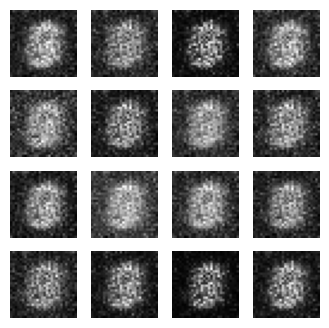

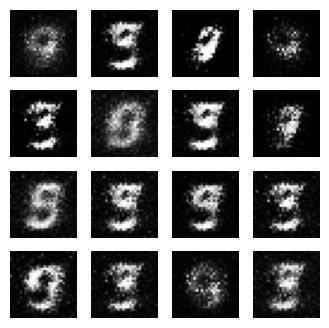

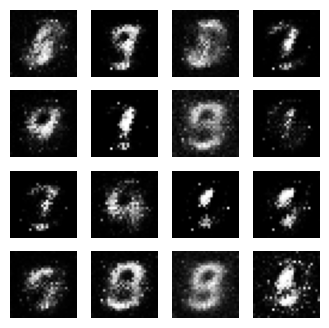

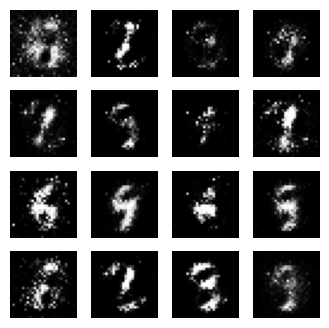

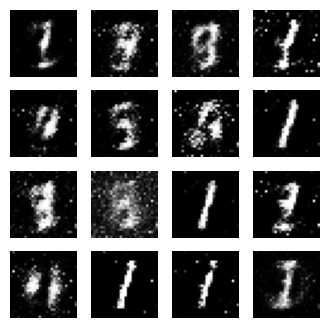

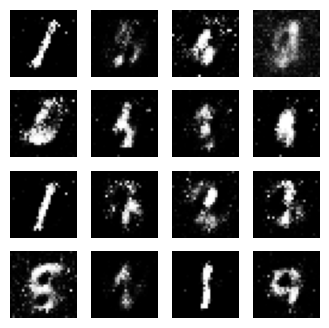

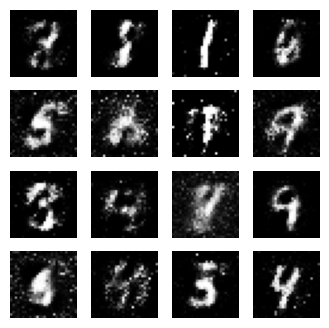

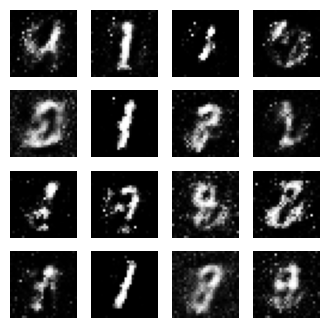

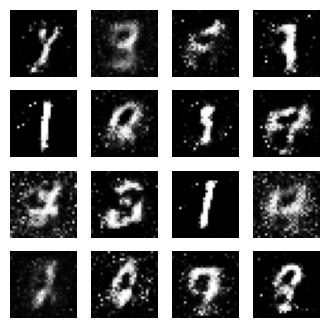

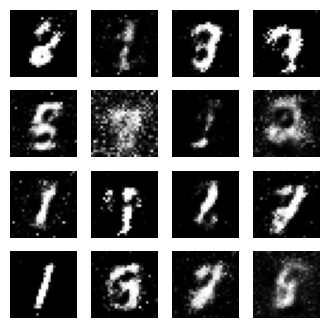

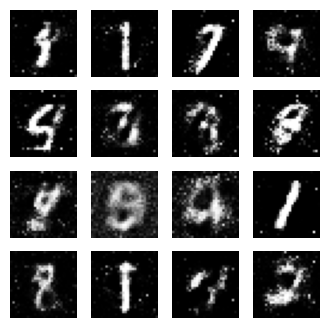

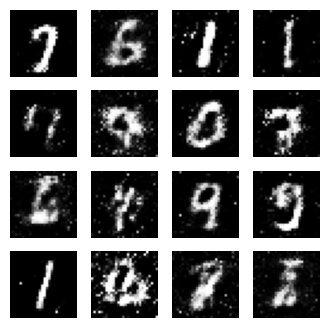

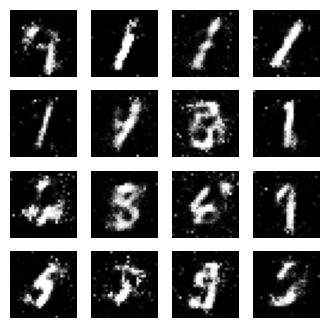

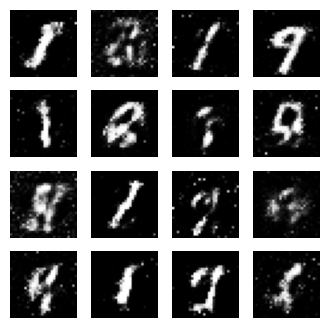

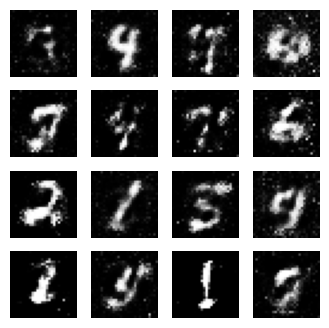

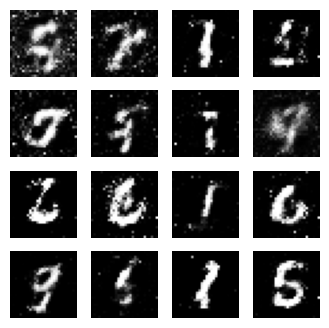

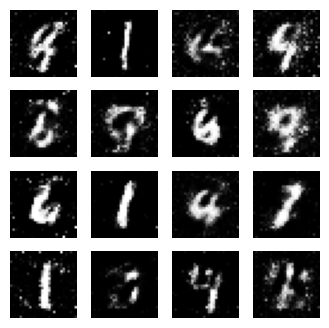

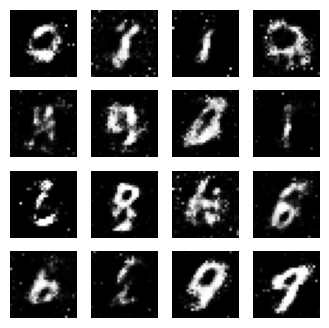

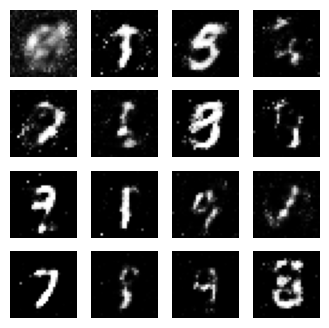

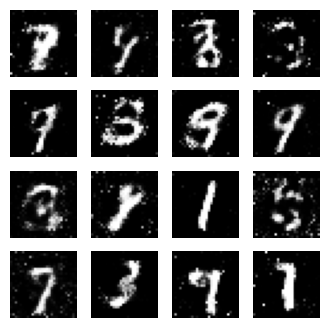

In [9]:
%%time
# 하이퍼파라미터 설정
iterations = 20000
batch_size = 256
sample_interval = 1000

# 지정된 반복 횟수만큼 GAN 훈련
train(iterations, batch_size, sample_interval)

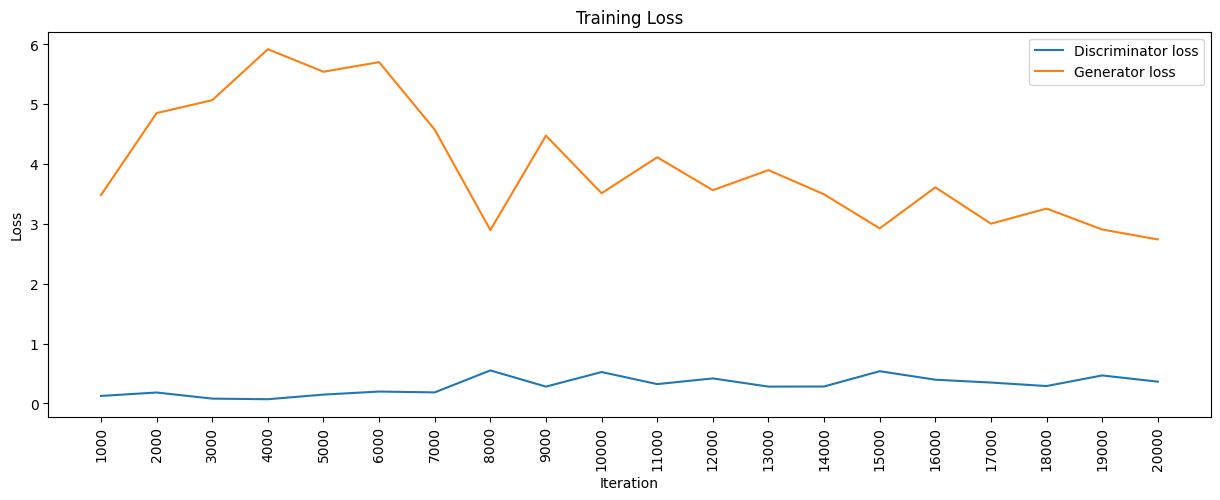

In [10]:
losses = np.array(losses)

# 판별자와 생성자의 훈련 손실 그래프
plt.figure(figsize=(15, 5))
plt.plot(iteration_checkpoints, losses.T[0], label="Discriminator loss")
plt.plot(iteration_checkpoints, losses.T[1], label="Generator loss")

plt.xticks(iteration_checkpoints, rotation=90)

plt.title("Training Loss")
plt.xlabel("Iteration")
plt.ylabel("Loss")
plt.legend()

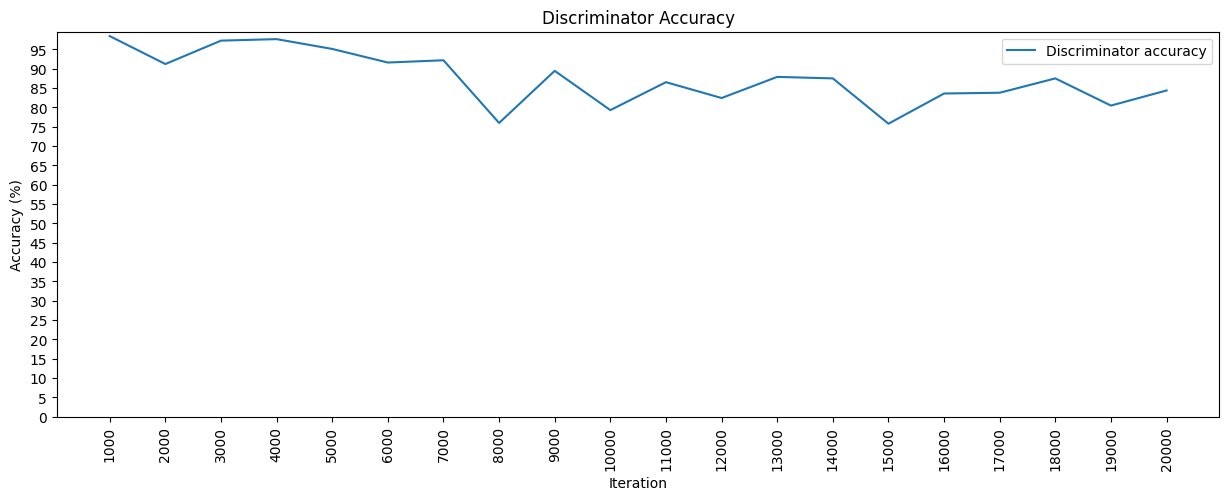

In [11]:
accuracies = np.array(accuracies)

# 판별자의 정확도 그래프
plt.figure(figsize=(15, 5))
plt.plot(iteration_checkpoints, accuracies, label="Discriminator accuracy")

plt.xticks(iteration_checkpoints, rotation=90)
plt.yticks(range(0, 100, 5))

plt.title("Discriminator Accuracy")
plt.xlabel("Iteration")
plt.ylabel("Accuracy (%)")
plt.legend()